In [6]:
import pandas as pd

# ------------------------------
#  Daten laden
# ------------------------------
transactions = pd.read_parquet("transactions_train_3.parquet")
transactions = transactions[transactions["label"]!= 'UNKNOWN']
transaction_lines = pd.read_parquet("transaction_lines_train_3.parquet")
transaction_lines["price"] = transaction_lines["sales_price"].astype("float32")
transaction_lines["camera_product_similar"] = transaction_lines["camera_product_similar"].astype("bool") 
transaction_lines["camera_certainty"] = transaction_lines["camera_certainty"].astype("float32")


products = pd.read_csv("products.csv")
stores = pd.read_csv("stores.csv")

# ------------------------------
#  Joins durchführen
# ------------------------------

# 1. JOIN transactions + transaction_lines
merged = transaction_lines.merge(transactions, left_on="transaction_id", right_on="id", suffixes=('_line', '_tx'))

# 2. JOIN mit products
merged = merged.merge(products, how="left", left_on="product_id", right_on="id")

# 3. JOIN mit stores
merged = merged.merge(stores, how="left", left_on="store_id",right_on="id")

# ------------------------------
#  Feature Engineering
# ------------------------------

# Transaktionsdauer
merged["transaction_duration"] = (merged["transaction_end"] - merged["transaction_start"]).dt.total_seconds()

# Uhrzeit-Features
merged["hour_of_day"] = merged["transaction_start"].dt.hour
merged["day_of_week"] = merged["transaction_start"].dt.dayofweek
merged["month"] = merged["transaction_start"].dt.month



In [7]:
merged.head()

,id_line,transaction_id,product_id,timestamp,pieces_or_weight,sales_price,was_voided,camera_product_similar,camera_certainty,price_x,...,id_y,opening_date,location,state,urbanization,sco_introduction,transaction_duration,hour_of_day,day_of_week,month
0,1,088ca87f-a94f-44c6-95ac-0750a2e25609,5e4b035b-97eb-4784-8d17-5fb9c55c9c65,2022-02-03 15:54:10.426291,6.0,8.34,False,False,0.353962,8.34,...,cd833b6b-0666-42df-b538-6bb1f189b66e,2000-10-05,Köln,Nordrhein-Westfalen,RURAL,2022-02-02,16.826924,15,3,2
1,2,088ca87f-a94f-44c6-95ac-0750a2e25609,fe909233-f36a-4981-a988-96086eea630b,2022-02-03 15:54:12.481666,2.0,1.98,False,False,0.235018,1.98,...,cd833b6b-0666-42df-b538-6bb1f189b66e,2000-10-05,Köln,Nordrhein-Westfalen,RURAL,2022-02-02,16.826924,15,3,2
2,1,6337ba12-5845-4456-addd-14ca8dfbf1c8,fc880d6a-6cfc-4627-8afb-6096eb8ba787,2022-02-03 17:22:26.205815,6.0,5.94,False,False,0.261068,5.94,...,cd833b6b-0666-42df-b538-6bb1f189b66e,2000-10-05,Köln,Nordrhein-Westfalen,RURAL,2022-02-02,130.380845,17,3,2
3,2,6337ba12-5845-4456-addd-14ca8dfbf1c8,e216509a-2f43-4c1b-80a0-184f7d35950c,2022-02-03 17:22:27.549572,2.0,3.58,False,False,0.296789,3.58,...,cd833b6b-0666-42df-b538-6bb1f189b66e,2000-10-05,Köln,Nordrhein-Westfalen,RURAL,2022-02-02,130.380845,17,3,2
4,3,6337ba12-5845-4456-addd-14ca8dfbf1c8,29d506a0-5b54-4bb8-92e8-79e24febd177,2022-02-03 17:22:30.015320,15.0,2.85,False,True,0.520240,2.85,...,cd833b6b-0666-42df-b538-6bb1f189b66e,2000-10-05,Köln,Nordrhein-Westfalen,RURAL,2022-02-02,130.380845,17,3,2


In [8]:
# 1. Berechne die Summe der Artikelpreise je Transaktion
sales_sum = merged.groupby("transaction_id")["sales_price"].sum().rename("sales_sum")

# 2. Extrahiere pro Transaktion einmalig total_amount & label (aus merged)
tx_info = merged.drop_duplicates(subset="transaction_id")[["transaction_id", "total_amount", "label"]]

# 3. Mergen zu einem neuen, aggregierten DataFrame
vergleich_df = tx_info.merge(sales_sum, on="transaction_id")

# 4. Differenz berechnen
vergleich_df["abweichung"] = vergleich_df["sales_sum"] - vergleich_df["total_amount"]

# 5. Optional: Nur signifikante Abweichungen anzeigen
abweichungen = vergleich_df[vergleich_df["abweichung"].abs() > 0.01]

# Ausgabe
print(f"Anzahl auffälliger Transaktionen: {len(abweichungen)}")
display(abweichungen.head())


Anzahl auffälliger Transaktionen: 10637


,transaction_id,total_amount,label,sales_sum,abweichung
13,cc6a0330-99be-4ee7-afcf-586b74c2e524,301.68,NORMAL,379.46,77.78
16,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,NORMAL,47.42,5.46
24,41b72fed-5461-45e0-8e84-c1d3dea02556,273.61,NORMAL,287.19,13.58
39,5bc97f9b-fc9d-4307-afee-9810d2a7815a,283.98,NORMAL,319.78,35.80
43,84654df5-56ed-43a3-bf00-9d8c7fd9523e,89.74,NORMAL,90.23,0.49


In [17]:
merged[merged.transaction_id == "e4410aae-94e5-40c5-a2ba-9350c2a32f4b"][["transaction_id", "total_amount", "sales_price","product_id","was_voided","label"]]

,transaction_id,total_amount,sales_price,product_id,was_voided,label
133,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,0.39,831879d1-52fd-43bf-9ecc-ca56abb163bc,False,NORMAL
134,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,9.56,fac24bfd-57b0-4760-8164-b371ddd8b380,False,NORMAL
135,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,4.76,c2cf3ccc-7f69-41ef-834d-0efe498a769a,False,NORMAL
136,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,5.94,23e73e87-83d4-4add-a206-e221efcb2537,False,NORMAL
137,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,4.47,1f633818-1b74-41fb-9af1-e82e4bb1c40f,False,NORMAL
138,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,5.46,4c9b4dd5-50d4-4890-9455-88c75470b1d7,False,NORMAL
139,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,5.46,4c9b4dd5-50d4-4890-9455-88c75470b1d7,True,NORMAL
140,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,0.49,f8b5e130-201b-4a3e-95a1-2d8002720e79,False,NORMAL
141,e4410aae-94e5-40c5-a2ba-9350c2a32f4b,41.96,10.89,8d13f6f4-133f-480b-a2f7-65ae7f1563da,False,NORMAL


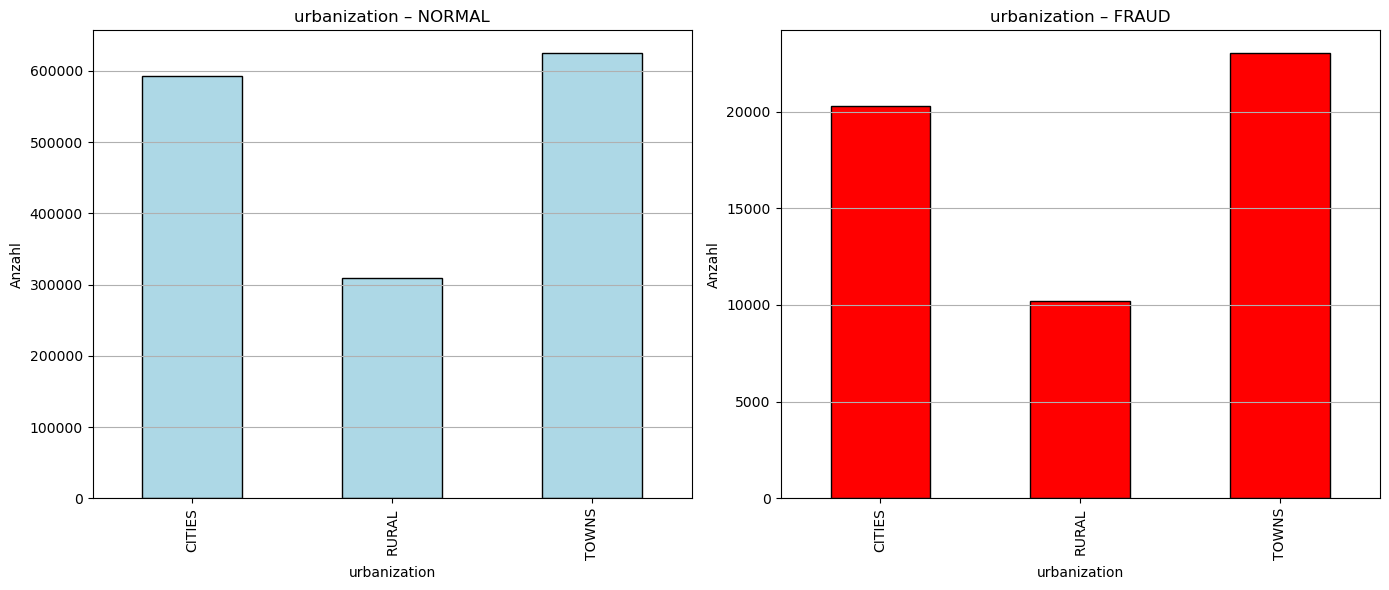

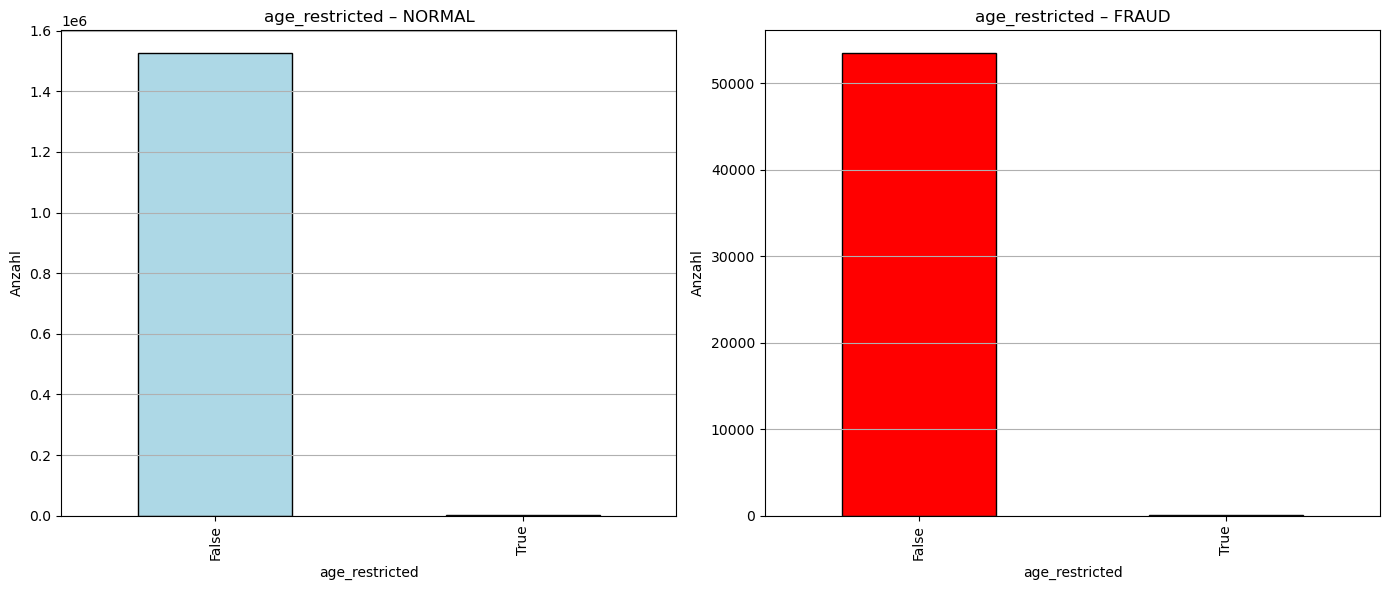

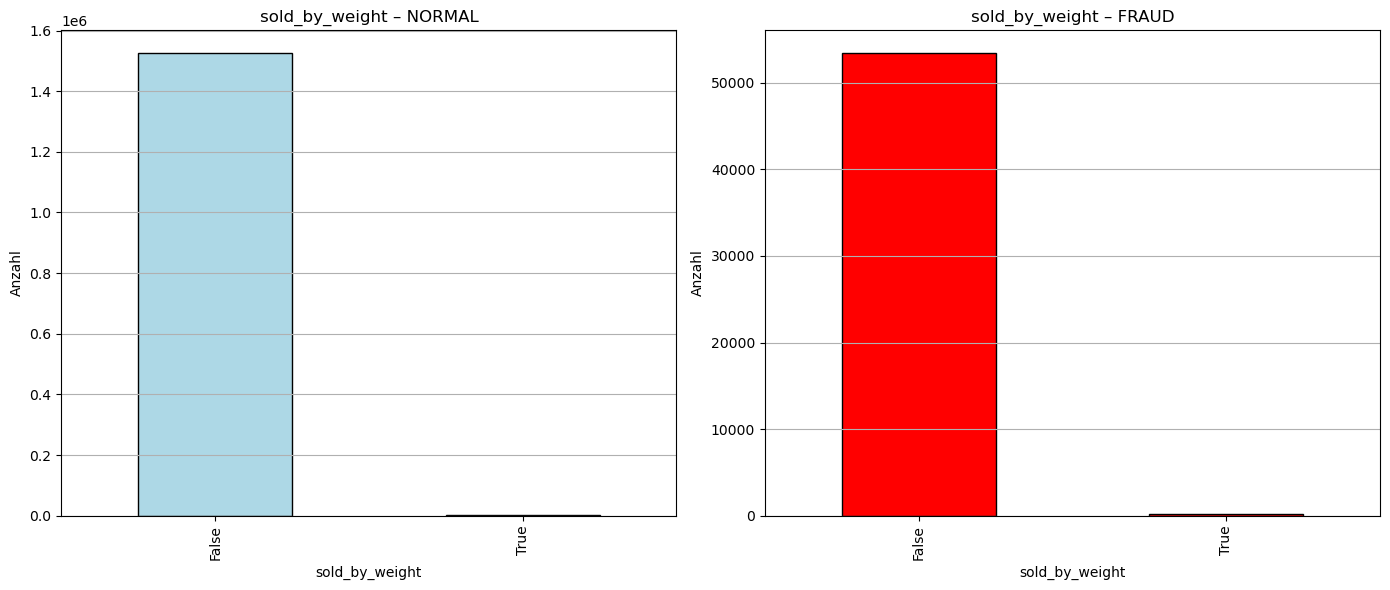

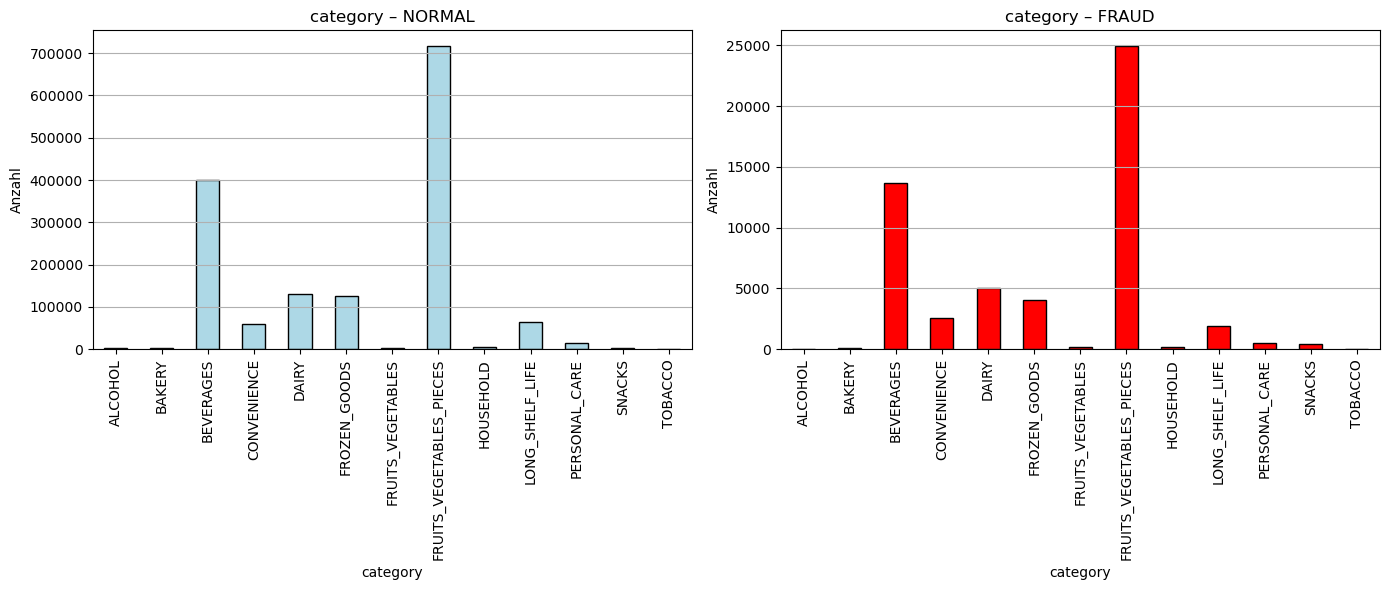

In [16]:
from scipy.stats import ttest_ind, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
# -------------------------------------
# Spalten definieren
# -------------------------------------
numerical_columns = ['popularity', 'price_x', 'weight']
categorical_columns = ['urbanization', 'age_restricted', 'sold_by_weight', 'category']



# benutzerdefinierte Sortierung der Wochentage
custom_sorts = {
    'weekday': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],

}

for col in categorical_columns:
    # Zähle die Werte pro Klasse
    counts_normal = merged[merged['label'] == 'NORMAL'][col].value_counts()
    counts_fraud = merged[merged['label'] == 'FRAUD'][col].value_counts()

    # Vereinheitlichte Liste aller vorkommenden Kategorien
    all_categories = sorted(set(counts_normal.index).union(counts_fraud.index))

    # Wenn benutzerdefinierte Sortierung existiert, verwende sie
    if col in custom_sorts:
        categories = [cat for cat in custom_sorts[col] if cat in all_categories]
    else:
        categories = all_categories  # Alphabetisch

    # Neuindizierung mit vollständiger Kategorie-Reihenfolge
    counts_normal = counts_normal.reindex(categories, fill_value=0)
    counts_fraud = counts_fraud.reindex(categories, fill_value=0)

    # Plot nebeneinander
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    counts_normal.plot(kind='bar', ax=axes[0], color='lightblue', edgecolor='black')
    axes[0].set_title(f'{col} – NORMAL')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Anzahl')
    axes[0].grid(axis='y')

    counts_fraud.plot(kind='bar', ax=axes[1], color='red', edgecolor='black')
    axes[1].set_title(f'{col} – FRAUD')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Anzahl')
    axes[1].grid(axis='y')

    plt.tight_layout()
    plt.show()


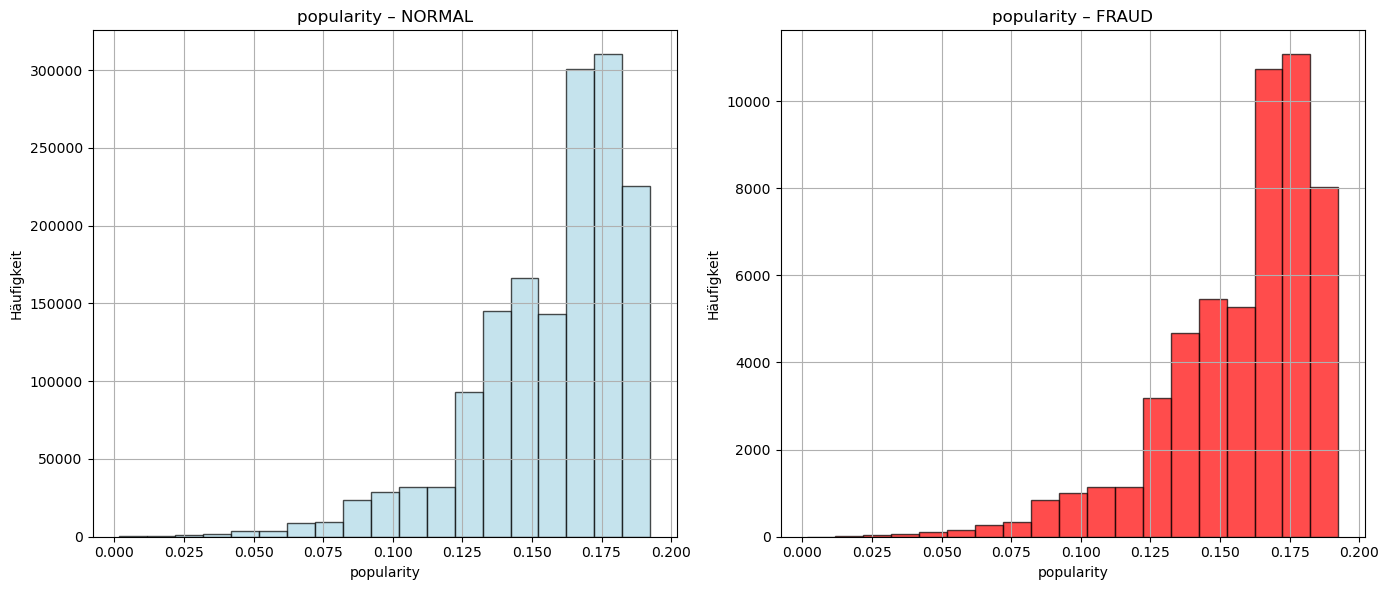

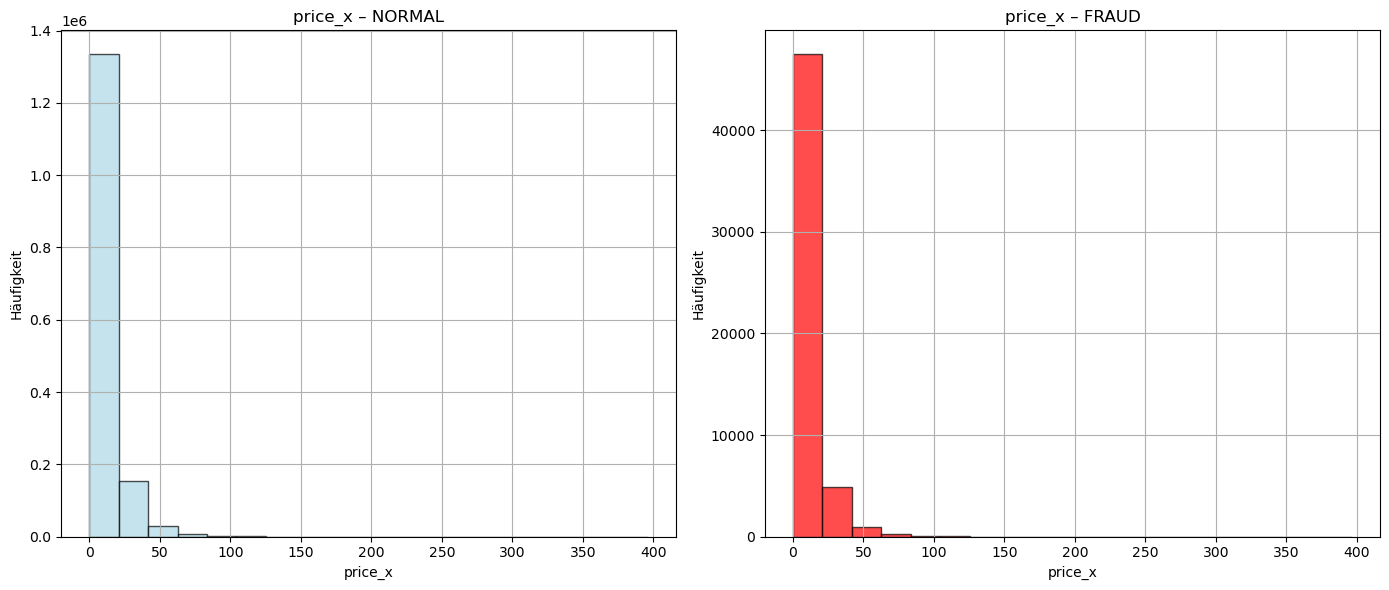

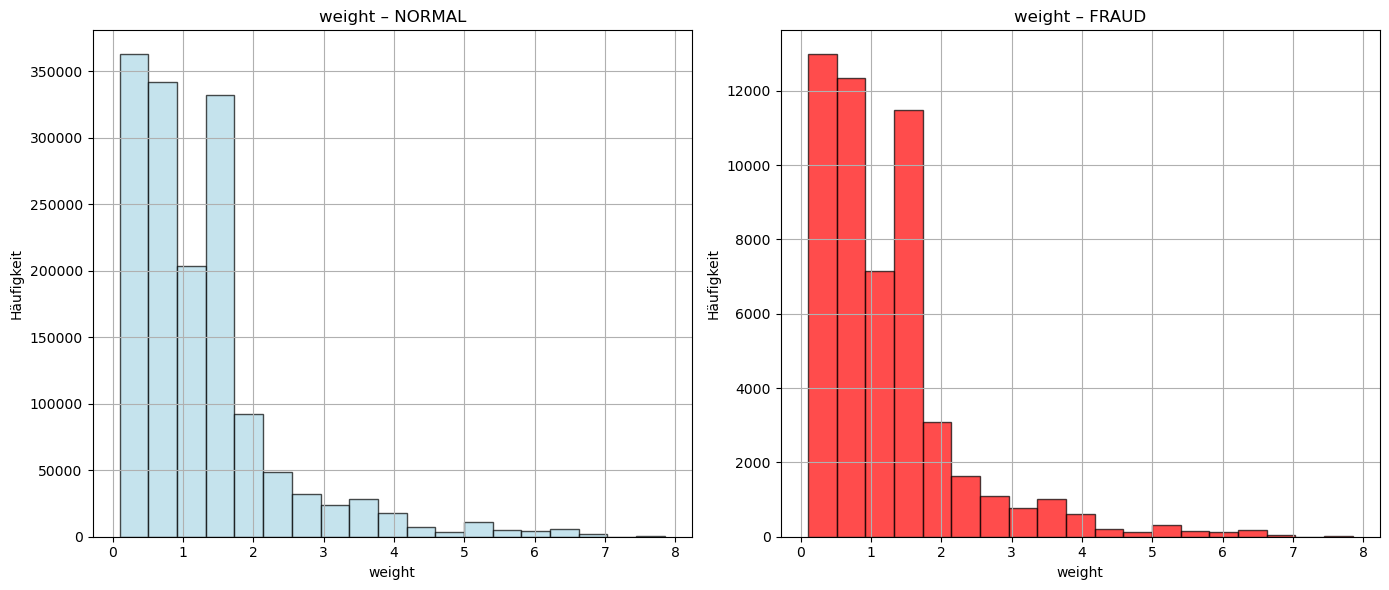

In [19]:
import numpy as np
import matplotlib.pyplot as plt

for col in numerical_columns:
    # Daten bereinigen: NaN und inf/-inf entfernen
    normal_data = merged[merged['label'] == 'NORMAL'][col].replace([np.inf, -np.inf], np.nan).dropna()
    fraud_data = merged[merged['label'] == 'FRAUD'][col].replace([np.inf, -np.inf], np.nan).dropna()

    # Skip falls Daten fehlen
    if normal_data.empty or fraud_data.empty:
        print(f"Spalte '{col}' hat keine gültigen Daten für eine der Gruppen – wird übersprungen.")
        continue

    # Gemeinsame Binning-Grenzen
    bins = 20
    min_val = min(normal_data.min(), fraud_data.min())
    max_val = max(normal_data.max(), fraud_data.max())

    if min_val == max_val:
        print(f"Spalte '{col}' hat keine Varianz – wird übersprungen.")
        continue

    bin_edges = np.linspace(min_val, max_val, bins)

    # Subplots nebeneinander
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # Histogramm NORMAL
    axes[0].hist(normal_data, bins=bin_edges, color='lightblue', edgecolor='black', alpha=0.7)
    axes[0].set_title(f'{col} – NORMAL')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Häufigkeit')
    axes[0].grid(True)

    # Histogramm FRAUD
    axes[1].hist(fraud_data, bins=bin_edges, color='red', edgecolor='black', alpha=0.7)
    axes[1].set_title(f'{col} – FRAUD')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Häufigkeit')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


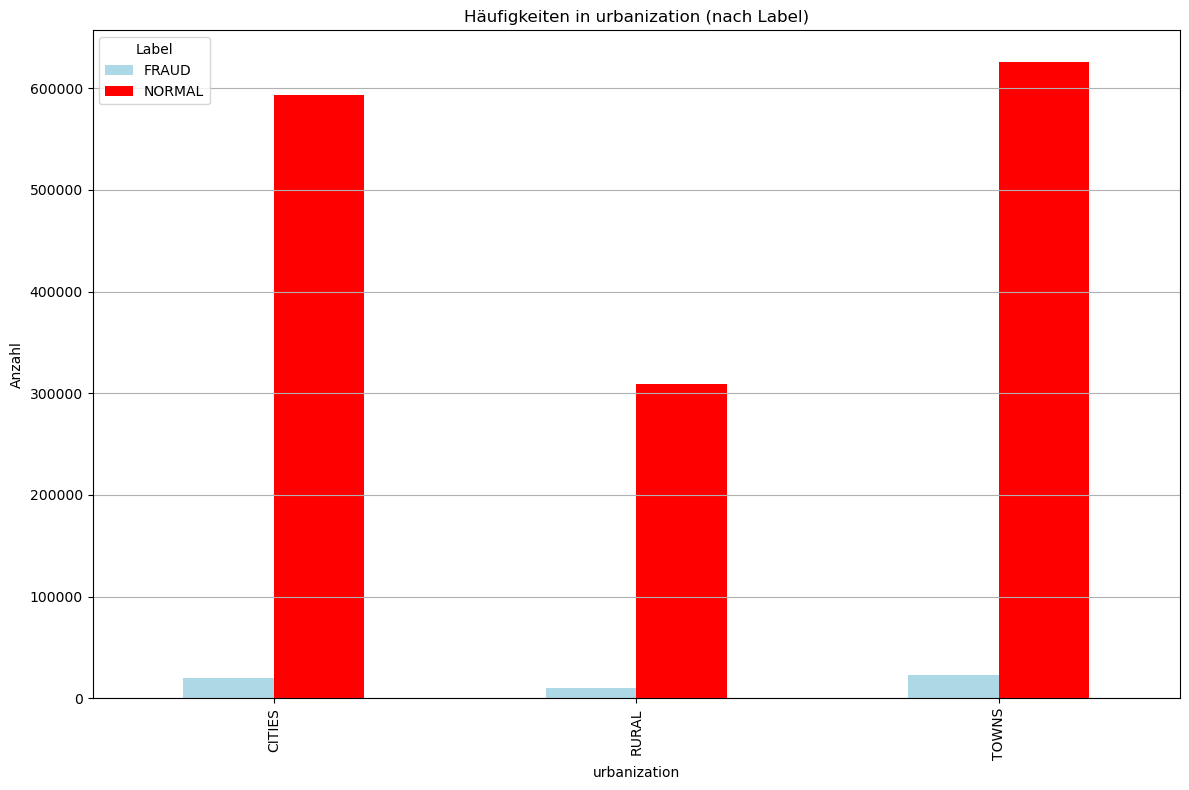


Absolute Häufigkeiten in 'urbanization':
label         FRAUD  NORMAL
urbanization               
CITIES        20286  593345
RURAL         10225  309083
TOWNS         23053  625575

Chi-Quadrat-Test für 'urbanization':
  Chi² = 101.01, p-Wert = 0.0000, Freiheitsgrade = 2
  ➜ Ergebnis ist signifikant (p < 0.05)
------------------------------------------------------------


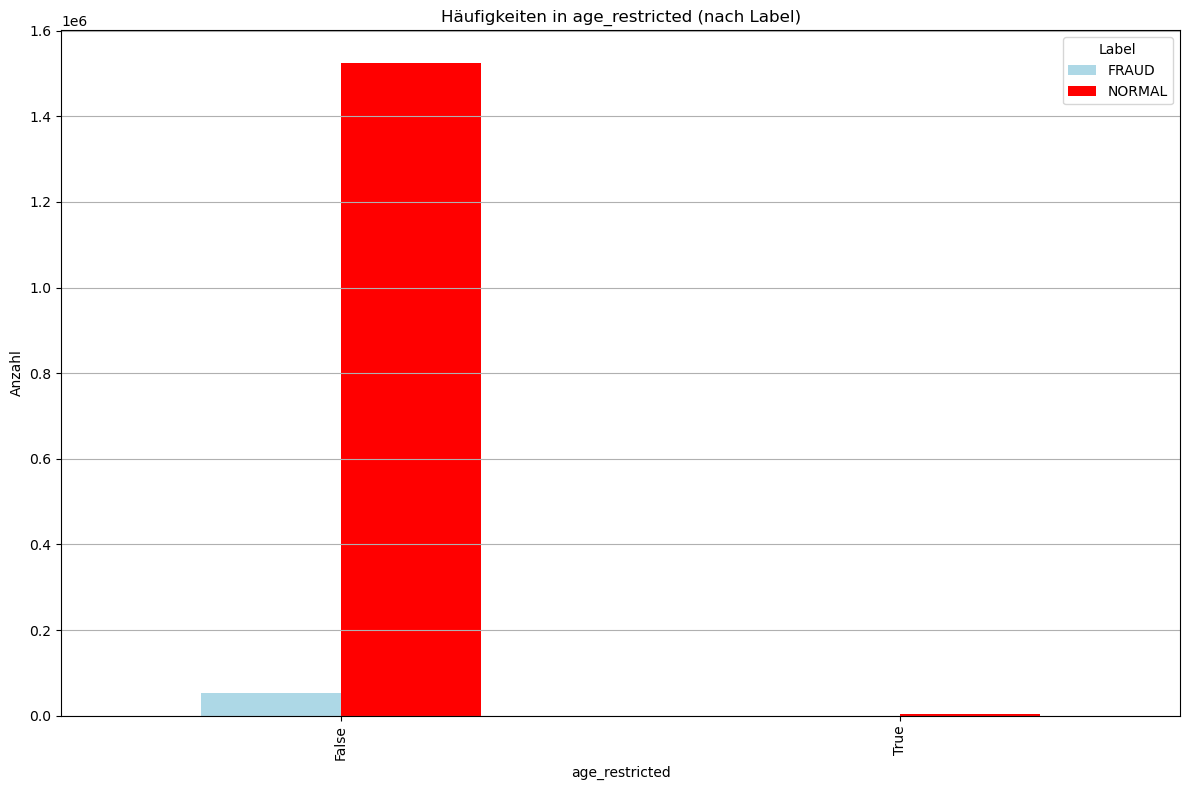


Absolute Häufigkeiten in 'age_restricted':
label           FRAUD   NORMAL
age_restricted                
False           53474  1524676
True               73     3327

Chi-Quadrat-Test für 'age_restricted':
  Chi² = 15.60, p-Wert = 0.0001, Freiheitsgrade = 1
  ➜ Ergebnis ist signifikant (p < 0.05)
------------------------------------------------------------


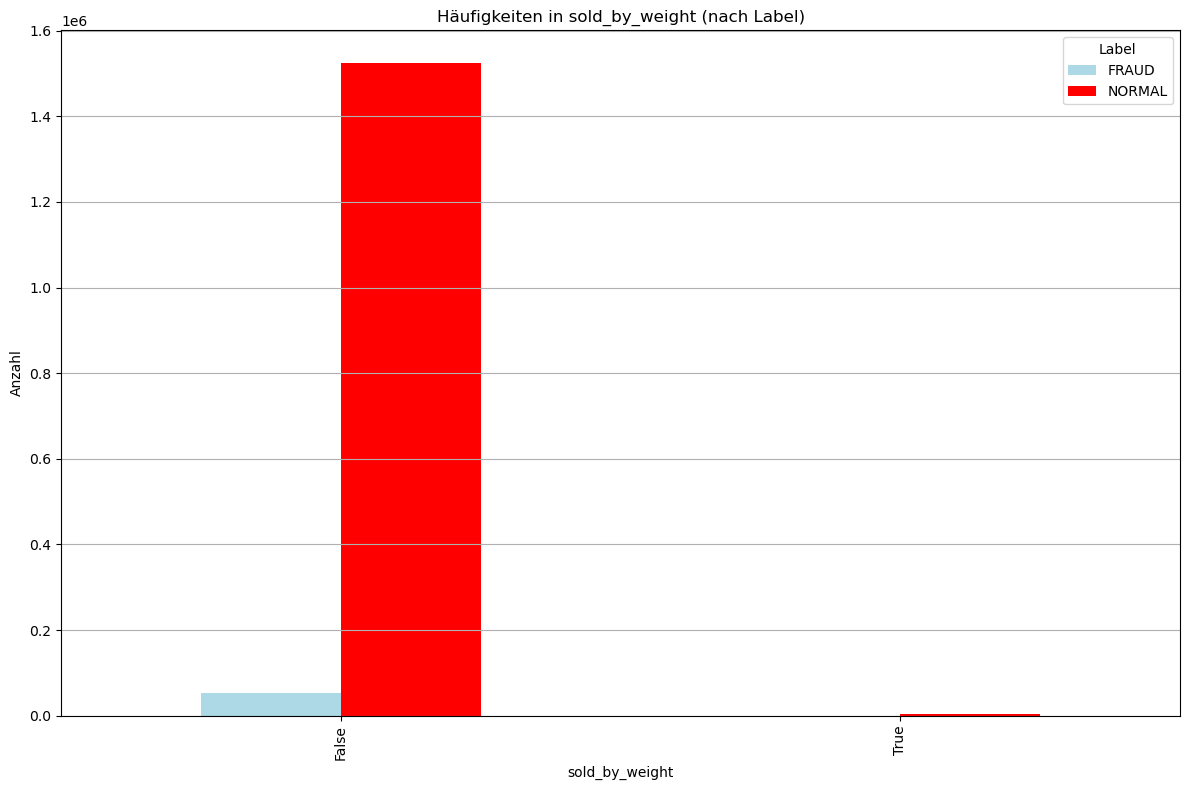


Absolute Häufigkeiten in 'sold_by_weight':
label           FRAUD   NORMAL
sold_by_weight                
False           53381  1524378
True              166     3625

Chi-Quadrat-Test für 'sold_by_weight':
  Chi² = 11.15, p-Wert = 0.0008, Freiheitsgrade = 1
  ➜ Ergebnis ist signifikant (p < 0.05)
------------------------------------------------------------


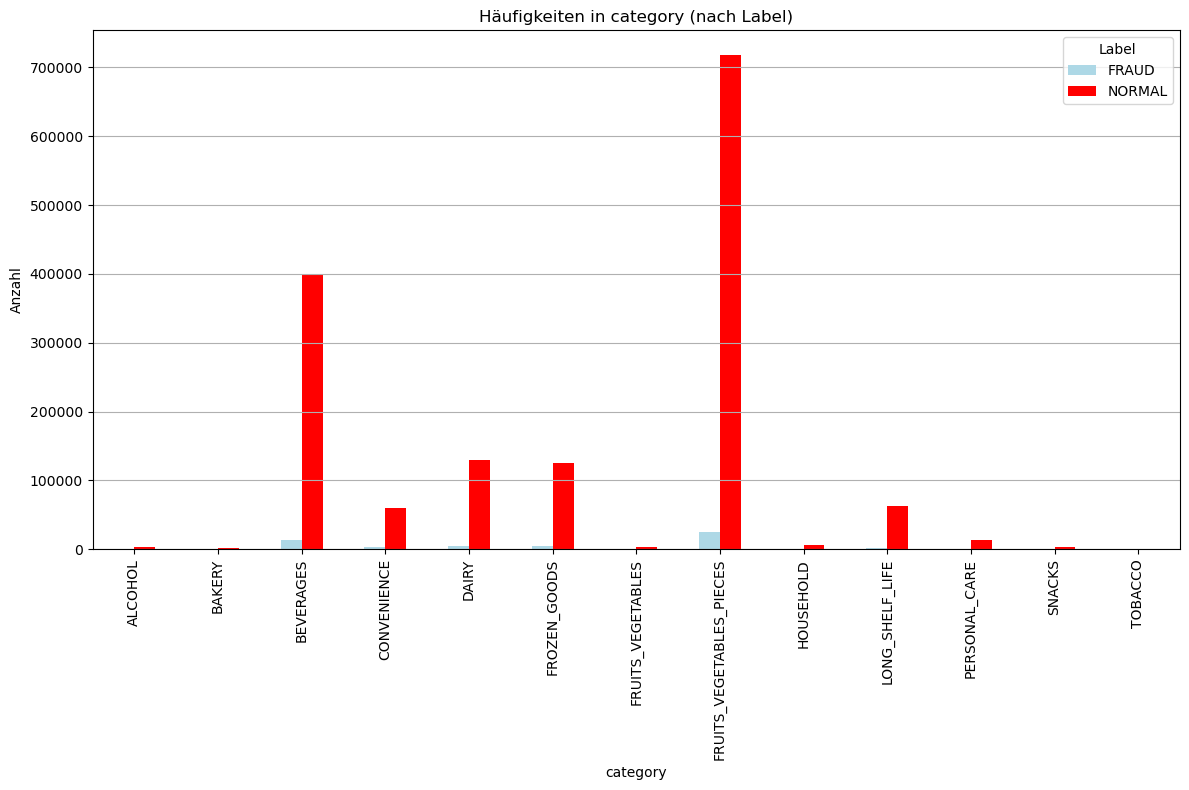


Absolute Häufigkeiten in 'category':
label                     FRAUD  NORMAL
category                               
ALCOHOL                      50    2506
BAKERY                       60    1963
BEVERAGES                 13692  399216
CONVENIENCE                2533   59624
DAIRY                      5032  130136
FROZEN_GOODS               4026  125612
FRUITS_VEGETABLES           166    3625
FRUITS_VEGETABLES_PIECES  24980  718061
HOUSEHOLD                   191    5922
LONG_SHELF_LIFE            1906   63448
PERSONAL_CARE               481   14006
SNACKS                      407    3063
TOBACCO                      23     821

Chi-Quadrat-Test für 'category':
  Chi² = 989.33, p-Wert = 0.0000, Freiheitsgrade = 12
  ➜ Ergebnis ist signifikant (p < 0.05)
------------------------------------------------------------


In [21]:
# -------------------------------------
# Chi-Quadrat-Test für kategorische Variablen
# -------------------------------------

from scipy.stats import chi2_contingency

for col in categorical_columns:
    # Kreuztabelle: absolute Häufigkeiten
    counts = pd.crosstab(merged[col], merged['label'])

    if counts.empty:
        print(f"Spalte '{col}' enthält keine gültigen Daten – wird übersprungen.")
        continue

    # Balkendiagramm: absolute Zahlen
    counts.plot(kind='bar', figsize=(12, 8), color=['lightblue', 'red'])
    plt.title(f'Häufigkeiten in {col} (nach Label)')
    plt.xlabel(col)
    plt.ylabel('Anzahl')
    plt.legend(title='Label')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Absolute Häufigkeiten ausgeben
    print(f"\nAbsolute Häufigkeiten in '{col}':")
    print(counts)

    # Chi-Quadrat-Test
    try:
        chi2, p, dof, expected = chi2_contingency(counts)
        print(f"\nChi-Quadrat-Test für '{col}':")
        print(f"  Chi² = {chi2:.2f}, p-Wert = {p:.4f}, Freiheitsgrade = {dof}")
        if p < 0.05:
            print("  ➜ Ergebnis ist signifikant (p < 0.05)")
        else:
            print("  ➜ Kein signifikanter Unterschied (p ≥ 0.05)")
    except ValueError as e:
        print(f"  Chi-Quadrat-Test konnte nicht durchgeführt werden: {e}")

    print('-' * 60)


In [22]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581567 entries, 0 to 1581566
Data columns (total 43 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   id_line                    1581567 non-null  int64         
 1   transaction_id             1581567 non-null  object        
 2   product_id                 1581550 non-null  object        
 3   timestamp                  1581567 non-null  datetime64[ns]
 4   pieces_or_weight           1581567 non-null  float64       
 5   sales_price                1581567 non-null  float64       
 6   was_voided                 1581567 non-null  bool          
 7   camera_product_similar     1581567 non-null  bool          
 8   camera_certainty           1577777 non-null  float32       
 9   price_x                    1581567 non-null  float32       
 10  id_tx                      1581567 non-null  object        
 11  store_id                   1581567 no

In [37]:
merged["sales_price_calc"] = merged["pieces_or_weight"] * merged["price_y"]

In [38]:
merged.head()[["sales_price_calc","sales_price","pieces_or_weight","price_y"]]

,sales_price_calc,sales_price,pieces_or_weight,price_y
0,8.34,8.34,6.0,1.39
1,1.98,1.98,2.0,0.99
2,5.94,5.94,6.0,0.99
3,3.58,3.58,2.0,1.79
4,2.85,2.85,15.0,0.19


In [39]:
merged["price_difference"] = merged["sales_price"] - merged["sales_price_calc"]

In [46]:
merged[merged["price_difference"] > 0.01]

,id_line,transaction_id,product_id,timestamp,pieces_or_weight,sales_price,was_voided,camera_product_similar,camera_certainty,price_x,...,sco_introduction,transaction_duration,hour_of_day,day_of_week,month,sales_sum_per_transaction,betrag_diff,sales_price_rechnerisch,sales_price_calc,price_difference


In [60]:
preis_diff =merged[merged["price_difference"].abs() > 0.6]

In [64]:
preis_diff.category.value_counts()

category
FRUITS_VEGETABLES_PIECES    11685
DAIRY                        3264
CONVENIENCE                  1730
BEVERAGES                     739
FROZEN_GOODS                  593
LONG_SHELF_LIFE               338
FRUITS_VEGETABLES             148
PERSONAL_CARE                  99
HOUSEHOLD                      52
BAKERY                         30
SNACKS                          4
ALCOHOL                         2
TOBACCO                         1
Name: count, dtype: int64

In [63]:
pd.set_option('display.max_columns', None)
preis_diff.head(4)

,id_line,transaction_id,product_id,timestamp,pieces_or_weight,sales_price,was_voided,camera_product_similar,camera_certainty,price_x,id_tx,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,customer_feedback,damage,label,id_x,base_product_id,category,price_y,popularity,valid_from,valid_to,sold_by_weight,weight,age_restricted,id_y,opening_date,location,state,urbanization,sco_introduction,transaction_duration,hour_of_day,day_of_week,month,sales_sum_per_transaction,betrag_diff,sales_price_rechnerisch,sales_price_calc,price_difference
154,2,59666bd2-221b-41cd-9fc7-fd3c33cc1413,02dc66fa-df62-496d-8a85-cb0cf6e8fb0e,2022-02-21 15:19:06.434998,21.0,17.49,False,True,1.000000,17.49,59666bd2-221b-41cd-9fc7-fd3c33cc1413,cd833b6b-0666-42df-b538-6bb1f189b66e,1,2022-02-21 15:18:45,2022-02-21 15:19:26.010269,19.02,3,CREDIT_CARD,NaN,0.0,NORMAL,02dc66fa-df62-496d-8a85-cb0cf6e8fb0e,a59f8e39-39da-47ca-a6fe-e2ca46350f69,FRUITS_VEGETABLES_PIECES,1.19,0.157641,2018-12-24,NaN,False,2.047141,False,cd833b6b-0666-42df-b538-6bb1f189b66e,2000-10-05,Köln,Nordrhein-Westfalen,RURAL,2022-02-02,41.010269,15,0,2,19.02,0.0,24.99,24.99,-7.50
267,9,de97d92b-dbe0-4290-a975-354beec3a89e,e76ab0f8-191d-4b0c-b7cb-93ca1a0b298f,2022-03-01 19:04:35.670450,7.0,6.81,False,True,1.000000,6.81,de97d92b-dbe0-4290-a975-354beec3a89e,cd833b6b-0666-42df-b538-6bb1f189b66e,1,2022-03-01 19:03:27,2022-03-01 19:06:36.407592,159.23,24,CREDIT_CARD,NaN,0.0,NORMAL,e76ab0f8-191d-4b0c-b7cb-93ca1a0b298f,e76ab0f8-191d-4b0c-b7cb-93ca1a0b298f,FRUITS_VEGETABLES_PIECES,1.39,0.151459,2014-03-13,2023-04-03,False,5.232171,False,cd833b6b-0666-42df-b538-6bb1f189b66e,2000-10-05,Köln,Nordrhein-Westfalen,RURAL,2022-02-02,189.407592,19,1,3,159.23,0.0,9.73,9.73,-2.92
268,10,de97d92b-dbe0-4290-a975-354beec3a89e,a74b2791-00a9-40c7-a185-a5056e04d71c,2022-03-01 19:04:45.814210,9.0,2.46,False,True,0.798674,2.46,de97d92b-dbe0-4290-a975-354beec3a89e,cd833b6b-0666-42df-b538-6bb1f189b66e,1,2022-03-01 19:03:27,2022-03-01 19:06:36.407592,159.23,24,CREDIT_CARD,NaN,0.0,NORMAL,a74b2791-00a9-40c7-a185-a5056e04d71c,a74b2791-00a9-40c7-a185-a5056e04d71c,FRUITS_VEGETABLES_PIECES,0.39,0.184993,2013-12-20,NaN,False,1.491340,False,cd833b6b-0666-42df-b538-6bb1f189b66e,2000-10-05,Köln,Nordrhein-Westfalen,RURAL,2022-02-02,189.407592,19,1,3,159.23,0.0,3.51,3.51,-1.05
367,5,5bc97f9b-fc9d-4307-afee-9810d2a7815a,cfa2b749-88b5-4d9c-83fa-f968e3ce9456,2022-02-11 21:58:39.892807,13.0,4.46,False,True,0.867516,4.46,5bc97f9b-fc9d-4307-afee-9810d2a7815a,46e6da32-f4b0-40f3-ada7-fc6ca81ed85d,1,2022-02-11 21:58:06,2022-02-11 22:01:42.737714,283.98,33,CREDIT_CARD,NaN,0.0,NORMAL,cfa2b749-88b5-4d9c-83fa-f968e3ce9456,cfa2b749-88b5-4d9c-83fa-f968e3ce9456,FRUITS_VEGETABLES_PIECES,0.49,0.181330,2015-03-02,NaN,False,1.450155,False,46e6da32-f4b0-40f3-ada7-fc6ca81ed85d,2004-10-05,Stuttgart,Baden-Württemberg,CITIES,2022-02-08,216.737714,21,4,2,319.78,35.8,6.37,6.37,-1.91
